# Credit Card Default Prediction - Data Exploration

### Introduction

Nearly a hundred macroeconomic datasets were pulled for this project, and they were engineered into a total of over 10,000 features. For that reason, only a small portion of them are able to be explored in-depth. There are two main questions of interest in this data exploration:

<ol>
    <li><b>How well des the variable correlate with the outcome variable?</b> Macroeconomic variables that do not follow the same trend as the aggregate credit card default rate will not do well to predict it.</li>
    <li><b>Does the variable track lead the outcome variable?</b> The variable needs to be a <i>leading predictor</i> of credit card defaults, as the goal is to predict future default rates.</li>
</ol>

To evaluate these items, a number of visualizations and analyses are performed for each series:
<ol>
    <li>The series is isolated and graphed as a time series against the actual credit card default rate. This shows both whether the two series are correlated and whether the independent series lags, leads, or overlaps the default rate.</li>
    <li>A scatter plot is created from the independent and dependent variables. While scatter plot sometimes have unusual-looking results for time-series data, this provides a visualization of how closely they are related, not just as a time series, but as though each month were an independent sample.</li>
    <li> A linear regression on the two variables to evaluate the statistical significance of their relationship, and to provide a more rigorous evaluation of the relationships explored graphically.</li>
</ol>

### Setting Up

The first steps are to set up the notebook. The required libraries are imported and the data that was created and wrangled in the macro_capstone_data_wrangling notebook are imported.

Additionally, a bootstrap_linreg function is declared that is used to evaluate the significance of the selected relationships to the dependent variable

In [1]:
import numpy as np
import pandas as pd
import fredapi
import datetime as dt
import calendar
import os
import matplotlib.pyplot as plt

In [2]:
ind_df = pd.read_pickle(r'data\ind_df.pkl')
dep_df = pd.read_pickle(r'data\dep_df.pkl')
dep_df_raw = pd.read_pickle(r'data\dep_df_raw.pkl')
dep_series = dep_df.iloc[:, 0]
dep_name = 'Credit Card Default Rate'

In [3]:
# Declare bootstrap function
def bootstrap_linreg(x, y, size=10000):
    """Takes in an array of x and an array of y, which are paired data, and a size as parameters. Performs linear regressions
    on the paried data and returns an array of slopes and an array of intercepts with length equal to the size parameter"""
    
    # Convert x and y to numpy arrays for use below
    x = np.asarray(x)
    y = np.asarray(y)
    
    # Set up the index array, as well as an array for the slope and interept replicates
    ind = np.arange(len(x))
    slope_reps = np.empty(size)
    intercept_reps = np.empty(size)

    # Generate replicates by running a linear regression on each generated set of pairs.
    for i in range(size):
        test_ind = np.random.choice(ind, size=len(ind))
        test_x, test_y = x[test_ind], y[test_ind]
        slope_reps[i], intercept_reps[i] = np.polyfit(test_x, test_y, 1)

    return slope_reps, intercept_reps


## Exploring the Data



### Data Exploration - Industrial Production

The Industrial Production Index measures all industrial production within the United States, including manufacturing, some natural resource production, and some utilities. It is generally known to track closely with economic output, as manufacturing is a large component of total economic activity. Industrial Production steadily increases over time as the economy grows, so the <i>year-over-year change</i> in industrial production is considered.

First, the time series graphs of both Industrial Production and the Credit Card Default Rate are plotted. As expected, Industrial Production has a very strong looking inverse relationship with credit card defaults. The variable looks as though it might begin to change before credit card defaults - for example, Industrial Production rises sharply in 1991, <i>after which</i> credit card defaults appear to fall.

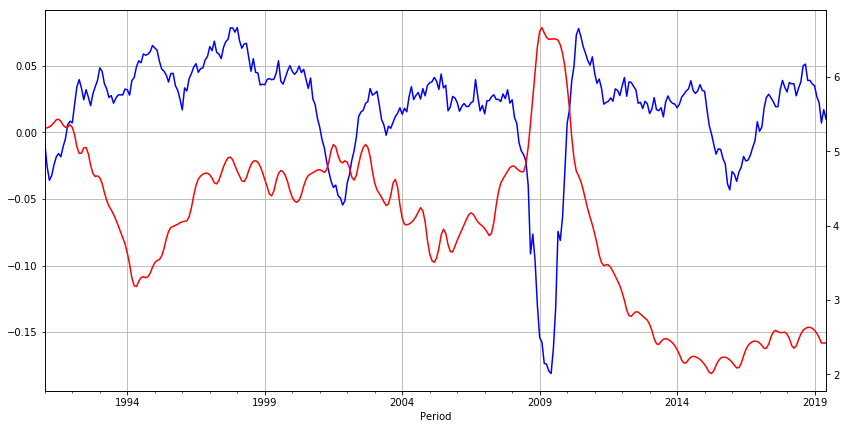

In [4]:
ind_series = ind_df.loc[:, 'INDPRO_12mth_per_ch']

plt.figure(figsize=(14,7))
plt.xlabel('Period')

ax1 = ind_series.plot(color='blue', grid=True, label='M2 Y-o-Y Change')
ax2 = dep_series.plot(color='red', grid=True, secondary_y=True, label='Credit Card Defaults')

Evaluating the scatter plot of Industrial Production vs. credit card defaults as though each data point is independent shows that there is a relatively persistent negative relationship between the two.

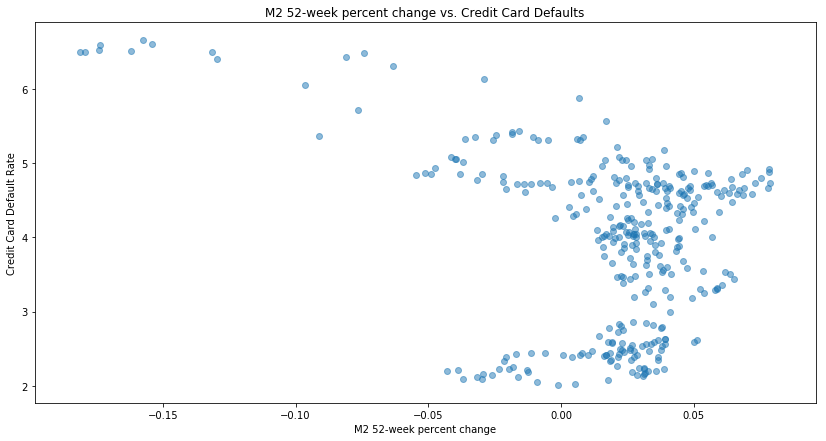

In [5]:
plt.figure(figsize=(14,7))

_ = plt.scatter(ind_series, dep_series, alpha=.5)
_ = plt.title('M2 52-week percent change vs. Credit Card Defaults')
_ = plt.xlabel('M2 52-week percent change')
_ = plt.ylabel('Credit Card Default Rate')

Finally, the relationship between the two variables is evaluated using linear regression. A statistically significant and very practically significant relationship is found to exist, with a 1% increase in the year-over-year change in industrial production being associated with a 0.085% decrease in the credit card default rate.

In [6]:
slope, intercept = bootstrap_linreg(ind_series, dep_series)
percentile_range = np.percentile(slope, [2.5, 97.5])
print(f'slope: {np.mean(slope)}\n95% CI: {percentile_range}')

slope: -8.503248251357846
95% CI: [-11.09141201  -4.98087989]


### Data Exploration - Consumer Sentiment

The University of Michigan conducts monthly surveys of consumers to evaluate how they perceive the health of the economy, the business environment, and their own personal finances. Results are aggregated into a single index that is designed to have a value of 100 during 1966Q1 - values greater than 100 represent sentiment that is better than this benchmark, and values less than 100 represent sentiment that is worse. It is expected that consumer sentiment and the credit card default rate are negatively correlated.

First, the two series are graphed over time - it is very common, as expected, for an increase in consumer sentiment to be associated with a decrease in the credit card default rate shortly after.

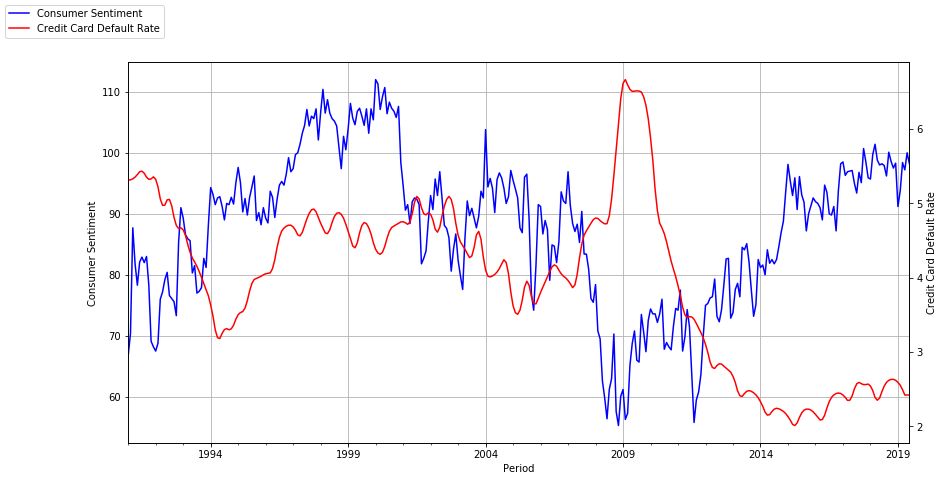

In [7]:
ind_series = ind_df.loc[:, 'UMCSENT_value']
ind_name = 'Consumer Sentiment'

fig = plt.figure(figsize=(14,7))
plt.xlabel('Period')

ax1 = ind_series.plot(color='blue', grid=True, label=ind_name)
ax1.set_ylabel(ind_name)
ax2 = dep_series.plot(color='red', grid=True, secondary_y=True, label=dep_name)
ax2.set_ylabel(dep_name)
_ = fig.legend(loc='upper left')


The scatter plot generated below appears to show a negative relationship between the value of the two variables plotted independent of the time that they occurred.

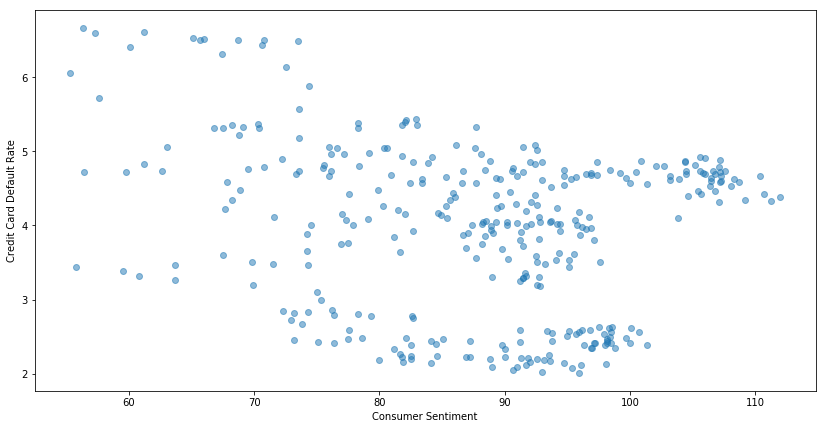

In [8]:
plt.figure(figsize=(14,7))

_ = plt.scatter(ind_series, dep_series, alpha=.5)
_ = plt.xlabel(ind_name)
_ = plt.ylabel(dep_name)

A linear regression was performed to verify this observed relationship - the 95% confidence interval for the relationship is -0.030 to  -0.009, suggesting that an increase in Consumer Sentiment by 1 is associated with a statistically significant ~0.02% decrease in the rate of credit card defaults.

In [9]:
slope, intercept = bootstrap_linreg(ind_series, dep_series)
percentile_range = np.percentile(slope, [2.5, 97.5])
print(f'slope: {np.mean(slope)}\n95% CI: {percentile_range}')

slope: -0.019589376840421488
95% CI: [-0.02995786 -0.00909943]


### Data Exploration - Recession Probability

The start date of a recession is often not identified until several months after its start. For this reason, there is value to predicting whether or not the economy is currently in recession. The Smoothed U.S. Recession Probabilities metric is a measure of the likelihood that a recession would occur during each month. As an economic recession typically severely increases credit card default rates, it is expected that a rise in the recession probability will be associated with an increase in defaults.

The chart below show the relationship between recession probabilities and the Credit Card Default Rate. The probability of a recession is typically zero, but when it increases it is often associated with an increase in the rate of credit card defaults, and it seems to be a leading indicator.

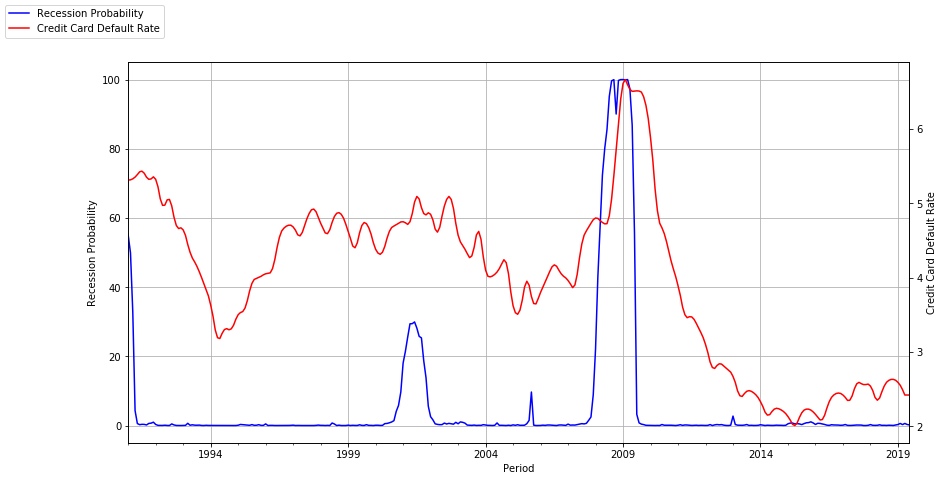

In [10]:
ind_series = ind_df.loc[:, 'RECPROUSM156N_value']
ind_name = 'Recession Probability'

fig = plt.figure(figsize=(14,7))
plt.xlabel('Period')

ax1 = ind_series.plot(color='blue', grid=True, label=ind_name)
ax1.set_ylabel(ind_name)
ax2 = dep_series.plot(color='red', grid=True, secondary_y=True, label=dep_name)
ax2.set_ylabel(dep_name)
_ = fig.legend(loc='upper left')


The scatter plot appears to show a negative relationship between the value of the two variables, but it is difficult to know how strong the relationship is as most values are clustered around a zero recession probability.

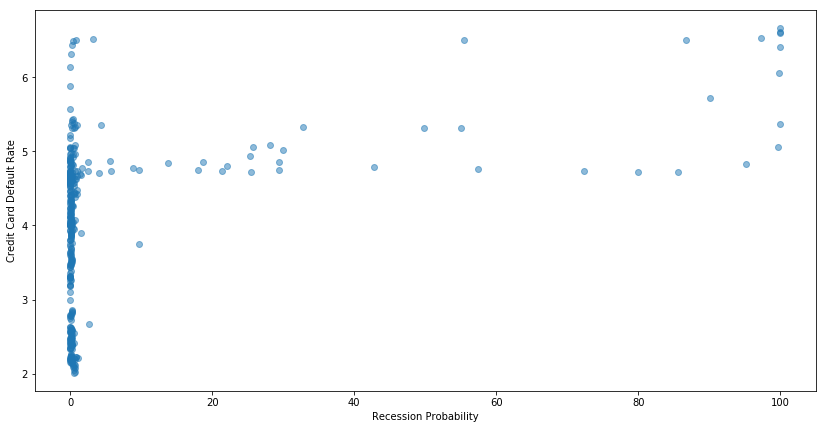

In [11]:
plt.figure(figsize=(14,7))

_ = plt.scatter(ind_series, dep_series, alpha=.5)
_ = plt.xlabel(ind_name)
_ = plt.ylabel(dep_name)

A linear regression was performed to evaluate the relationship - the 95% confidence interval is 0.019 to  0.027, suggesting that an increase in the recession probability of 1% is associated with a statistically significant ~0.023% increase in the rate of credit card defaults.

In [12]:
slope, intercept = bootstrap_linreg(ind_series, dep_series)
percentile_range = np.percentile(slope, [2.5, 97.5])
print(f'slope: {np.mean(slope)}\n95% CI: {percentile_range}')

slope: 0.02328421524538655
95% CI: [0.01930638 0.02734766]


### Data Exploration - Household Debt Service Payments

Debt service payments represent the proportion of the average household's income that goes to debt payment. A high rate of debt might be expected to predict a higher rate of loan default.

The figure below shows that debt service payments have historically tracked credit card defaults very well, <i>and</i> that they are a significantly leading indicator.

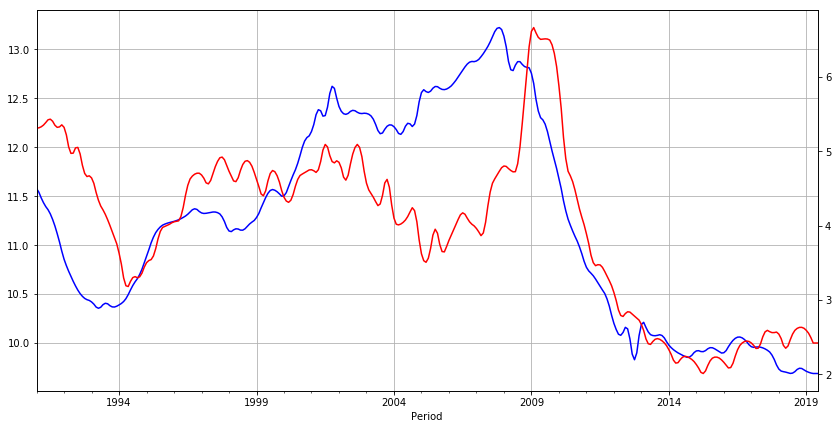

In [13]:
ind_series = ind_df.loc[:, 'TDSP_interp_quad_TDSP']

plt.figure(figsize=(14,7))
plt.xlabel('Period')

ax1 = ind_series.plot(color='blue', grid=True, label='M2 Y-o-Y Change')
ax2 = dep_series.plot(color='red', grid=True, secondary_y=True, label='Credit Card Defaults')

The scatter plot of the data shows a very unusual shape due to the two time series tracking closely but at different levels over time. In general, it appears to show a strong positive relationship between the two variables.

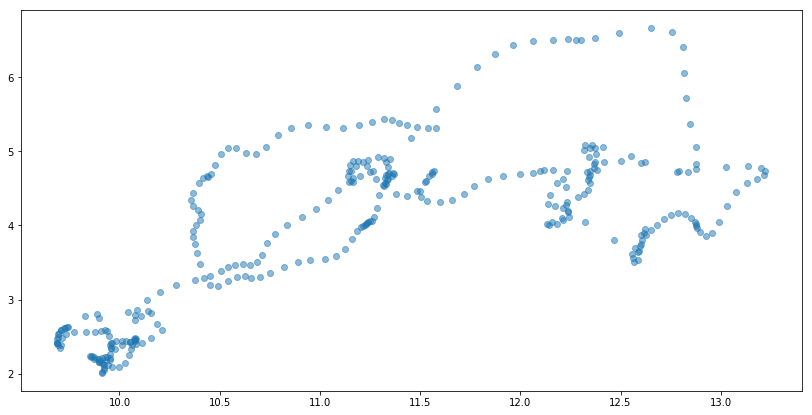

In [14]:
plt.figure(figsize=(14,7))

_ = plt.scatter(ind_series, dep_series, alpha=.5)

Regressing household debt service on aggregate credit card defaults shows that there is a strong and very significant relationship between the two - a one percentage point increase in debt-to-income is associated with a ~0.76% increase in the aggregate loan default rate.

In [15]:
slope, intercept = bootstrap_linreg(ind_series, dep_series)
percentile_range = np.percentile(slope, [2.5, 97.5])
print(f'slope: {np.mean(slope)}\n95% CI: {percentile_range}')

slope: 0.7445572251782729
95% CI: [0.66580981 0.82740194]


### Data Exploration - The Unemployment Rate

The Unemployment Rate is the proportion of those in the labor force who are actively employed. It is expected to track credit card default rates closely, as unemployment is a significant cause of inability to repay debts.

The graph below shows that there is a relationship between the two variables, but that it is not always strong - there is a spike in unemployment around 2001, for example, that is not observed in the credit card default rate. Additionally, counter to expectation, the unemployment late significantly lags the credit card default rate.

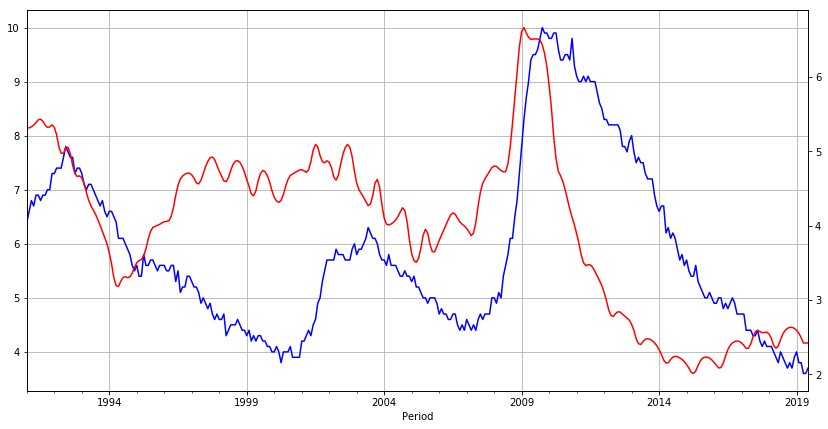

In [16]:
ind_series = ind_df.loc[:, 'UNRATE_value']

plt.figure(figsize=(14,7))
plt.xlabel('Period')

ax1 = ind_series.plot(color='blue', grid=True, label='M2 Y-o-Y Change')
ax2 = dep_series.plot(color='red', grid=True, secondary_y=True, label='Credit Card Defaults')

The scatter plot relating the two series shows a clear positive relationship.

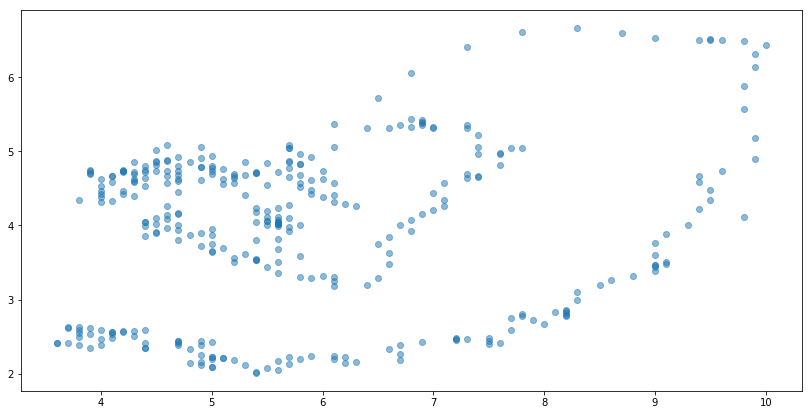

In [17]:
plt.figure(figsize=(14,7))

_ = plt.scatter(ind_series, dep_series, alpha=.5)

A linear regression of the two variables bears out this relationship - a 1% increase in the unemployment rate is associated with a statistically significant 0.16% increase in the rate of credit card defaults.

In [18]:
slope, intercept = bootstrap_linreg(ind_series, dep_series)
percentile_range = np.percentile(slope, [2.5, 97.5])
print(f'slope: {np.mean(slope)}\n95% CI: {percentile_range}')

slope: 0.1660762049853732
95% CI: [0.08632553 0.24467817]
